# Importing Libraries

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# For handling warnings
import warnings
warnings.filterwarnings('ignore')


# Loading the Data

In [16]:
# Define data types for memory optimization
dtype_events = {
    'event_timestamp': 'str',
    'region': 'category',
    'ua_device_type': 'category',
    'ua_client_type': 'category',
    'ua_os': 'category',
    'ua_client_name': 'category',
    'total_watchtime': 'int32',
    'rutube_video_id': 'category',
    'viewer_uid': 'int32'
}

dtype_video_info = {
    'rutube_video_id': 'category',
    'title': 'object',
    'category': 'category',
    'duration': 'int32',
    'author_id': 'int32'
}

dtype_targets = {
    'viewer_uid': 'int32',
    'sex': 'category',
    'age': 'int8'
}

# Load train_events.csv
train_events = pd.read_csv('./data/train_events.csv', dtype=dtype_events, parse_dates=['event_timestamp'])
print(f"Train Events Shape: {train_events.shape}")

# Load video_info.csv
video_info = pd.read_csv('./data/video_info_v2.csv', dtype=dtype_video_info)
print(f"Video Info Shape: {video_info.shape}")

# Load train_targets.csv
train_targets = pd.read_csv('./data/train_targets.csv', dtype=dtype_targets)
print(f"Train Targets Shape: {train_targets.shape}")

Train Events Shape: (1759616, 9)
Video Info Shape: (481480, 5)
Train Targets Shape: (180012, 4)


# Feature Engineering
## Ideas for Combined Features
1. Browser and OS Combination: Combine ua_client_name and ua_os to capture browser-OS usage patterns.
2. Device and Client Type: Combine ua_device_type and ua_client_type to differentiate between device and client usage.
3. Browser, OS, and Device: A three-way combination to capture more granular usage patterns.
4. Time-Based Features: Extract hour of the day, day of the week from event_timestamp adjusted to regional time.
5. Video Categories Interaction: Interaction between user regions and video categories.
6. Watchtime Features: Aggregate statistics like total watchtime, average watchtime per session.
7. Author Popularity: Number of videos watched per author.
8. Video Duration Buckets: Categorize video durations into short, medium, long.

In [17]:
# Приводим временную метку к формату datetime с учетом часового пояса
train_events['event_timestamp'] = pd.to_datetime(train_events['event_timestamp'])

region_timezones = {
    'Chelyabinsk': 'Asia/Yekaterinburg',
    'Bashkortostan Republic': 'Asia/Yekaterinburg',
    'St.-Petersburg': 'Europe/Moscow',
    'Moscow': 'Europe/Moscow',
    'Moscow Oblast': 'Europe/Moscow',
    'Tatarstan Republic': 'Europe/Moscow',
    'Novosibirsk Oblast': 'Asia/Novosibirsk',
    'Omsk Oblast': 'Asia/Omsk',
    'Chuvashia': 'Europe/Moscow',
    'Krasnoyarsk Krai': 'Asia/Krasnoyarsk',
    'Kamchatka': 'Asia/Kamchatka',
    'Nizhny Novgorod Oblast': 'Europe/Moscow',
    'Krasnodar Krai': 'Europe/Moscow',
    'Volgograd Oblast': 'Europe/Moscow',
    'Kaliningrad Oblast': 'Europe/Kaliningrad',
    'Kuzbass': 'Asia/Novosibirsk',
    'Stavropol Kray': 'Europe/Moscow',
    'Samara Oblast': 'Europe/Samara',
    'Amur Oblast': 'Asia/Yakutsk',
    'Sverdlovsk Oblast': 'Asia/Yekaterinburg',
    'Yamalo-Nenets': 'Asia/Yekaterinburg',
    'Orenburg Oblast': 'Asia/Yekaterinburg',
    'Khanty-Mansia': 'Asia/Yekaterinburg',
    'Kaluga Oblast': 'Europe/Moscow',
    'Tomsk Oblast': 'Asia/Novosibirsk',
    'Novgorod Oblast': 'Europe/Moscow',
    'Arkhangelskaya': 'Europe/Moscow',
    'North Ossetia–Alania': 'Europe/Moscow',
    'Kursk Oblast': 'Europe/Moscow',
    "Leningradskaya Oblast'": 'Europe/Moscow',
    'Krasnoyarskiy': 'Asia/Krasnoyarsk',
    'Ivanovo Oblast': 'Europe/Moscow',
    'Altay Kray': 'Asia/Barnaul',
    'Kurgan Oblast': 'Asia/Yekaterinburg',
    'Kostroma Oblast': 'Europe/Moscow',
    'Bryansk Oblast': 'Europe/Moscow',
    'Dagestan': 'Europe/Moscow',
    'Lipetsk Oblast': 'Europe/Moscow',
    'Vladimir Oblast': 'Europe/Moscow',
    'Kirov Oblast': 'Europe/Moscow',
    'Khabarovsk': 'Asia/Khabarovsk',
    'Tambov Oblast': 'Europe/Moscow',
    'Chukotka': 'Asia/Anadyr',
    'Voronezh Oblast': 'Europe/Moscow',
    'Sverdlovsk': 'Asia/Yekaterinburg',
    'Tula Oblast': 'Europe/Moscow',
    'Krasnodarskiy': 'Europe/Moscow',
    'Irkutsk Oblast': 'Asia/Irkutsk',
    'Saratov Oblast': 'Europe/Samara',
    'Khakasiya Republic': 'Asia/Krasnoyarsk',
    'Penza': 'Europe/Moscow',
    'Perm Krai': 'Europe/Yekaterinburg',
    'Oryol oblast': 'Europe/Moscow',
    'Vladimir': 'Europe/Moscow',
    'Smolensk Oblast': 'Europe/Moscow',
    'Penza Oblast': 'Europe/Moscow',
    'Mordoviya Republic': 'Europe/Moscow',
    'Tyumen’ Oblast': 'Asia/Yekaterinburg',
    'Sakha': 'Asia/Yakutsk',
    'Primorye': 'Asia/Vladivostok',
    'Zabaykalskiy (Transbaikal) Kray': 'Asia/Chita',
    'Vologda Oblast': 'Europe/Moscow',
    'Yaroslavl Oblast': 'Europe/Moscow',
    'Crimea': 'Europe/Moscow',
    'Rostov': 'Europe/Moscow',
    'Ryazan Oblast': 'Europe/Moscow',
    'Perm': 'Europe/Yekaterinburg',
    'Chechnya': 'Europe/Moscow',
    'Udmurtiya Republic': 'Asia/Yekaterinburg',
    'Tver Oblast': 'Europe/Moscow',
    'Buryatiya Republic': 'Asia/Ulan-Ude',
    'Belgorod Oblast': 'Europe/Moscow',
    'Kaluga': 'Europe/Moscow',
    'Astrakhan Oblast': 'Europe/Astrakhan',
    'Karelia': 'Europe/Moscow',
    'Murmansk': 'Europe/Moscow',
    'Adygeya Republic': 'Europe/Moscow',
    'Kemerovo Oblast': 'Asia/Novosibirsk',
    'Mariy-El Republic': 'Europe/Moscow',
    'Kursk': 'Europe/Moscow',
    'Saratovskaya Oblast': 'Europe/Samara',
    'Sakhalin Oblast': 'Asia/Vladivostok',
    'Ivanovo': 'Europe/Moscow',
    'Tyumen Oblast': 'Asia/Yekaterinburg',
    'Stavropol’ Kray': 'Europe/Moscow',
    'Voronezj': 'Europe/Moscow',
    'Karachayevo-Cherkesiya Republic': 'Europe/Moscow',
    'Kabardino-Balkariya Republic': 'Europe/Moscow',
    'Ulyanovsk': 'Europe/Moscow',
    'North Ossetia': 'Europe/Moscow',
    'Komi': 'Europe/Moscow',
    'Smolensk': 'Europe/Moscow',
    'Tver’ Oblast': 'Europe/Moscow',
    'Sebastopol City': 'Europe/Moscow',
    'Pskov Oblast': 'Europe/Moscow',
    'Tula': 'Europe/Moscow',
    'Orel Oblast': 'Europe/Moscow',
    'Jaroslavl': 'Europe/Moscow',
    'Tambov': 'Europe/Moscow',
    'Kalmykiya Republic': 'Europe/Moscow',
    'Primorskiy (Maritime) Kray': 'Asia/Vladivostok',
    'Altai': 'Asia/Barnaul',
    'Magadan Oblast': 'Asia/Magadan',
    'Vologda': 'Europe/Moscow',
    'Tyva Republic': 'Asia/Kyzyl',
    'Nenets': 'Europe/Moscow',
    'Smolenskaya Oblast’': 'Europe/Moscow',
    'Jewish Autonomous Oblast': 'Asia/Yakutsk',
    'Astrakhan': 'Europe/Astrakhan',
    'Ingushetiya Republic': 'Europe/Moscow',
    'Kirov': 'Europe/Moscow',
    'Transbaikal Territory': 'Asia/Chita',
    'Omsk': 'Asia/Omsk',
    'Kaliningrad': 'Europe/Kaliningrad',
    'Stavropol Krai': 'Europe/Moscow',
    'Arkhangelsk Oblast': 'Europe/Moscow',
}


from pytz import timezone

def convert_to_local_time(row):
    region = row['region']
    timestamp = row['event_timestamp']
    try:
        # Получаем часовой пояс региона, по умолчанию 'Europe/Moscow'
        tz = timezone(region_timezones.get(region, 'Europe/Moscow'))
    except:
        tz = timezone('Europe/Moscow')
    
    # Проверяем, является ли временная метка timezone-aware
    if timestamp.tzinfo is None or timestamp.tzinfo.utcoffset(timestamp) is None:
        # Если временная метка naive, локализуем её к московскому времени
        timestamp = timestamp.tz_localize('Europe/Moscow')
    
    # Преобразуем время в локальный часовой пояс региона
    return timestamp.astimezone(tz)


#all_events['local_event_timestamp'] = all_events.apply(convert_to_local_time, axis=1)
train_events['local_event_timestamp'] = train_events.apply(convert_to_local_time, axis=1)

## Processing ua_client_name and ua_os

In [18]:
# Keep only top 13 browsers, label others as 'other'
top_13_browsers = train_events['ua_client_name'].value_counts().nlargest(13).index
train_events['ua_client_name'] = train_events['ua_client_name'].apply(lambda x: x if x in top_13_browsers else 'other')

train_events.loc[train_events['ua_os'].isna(), 'ua_os'] = 'Android'
linux_distributions = ['GNU/Linux', 'Ubuntu', 'Debian', 'SUSE', 'CentOS', 'Fedora', 'NetBSD', 'OpenBSD']
train_events['ua_os'] = train_events['ua_os'].replace(linux_distributions, 'Linux')
train_events['ua_os'].value_counts()

# Keep only top 5 os, label others as 'other'
top_5_os = train_events['ua_os'].value_counts().nlargest(5).index
train_events['ua_os'] = train_events['ua_os'].apply(lambda x: x if x in top_5_os else 'other')

## Creating Combined Features

In [19]:
from scipy.stats import mstats
train_events['browser_os'] = train_events['ua_client_name'].astype(str) + '_' + train_events['ua_os'].astype(str)
train_events['device_client'] = train_events['ua_device_type'].astype(str) + '_' + train_events['ua_client_type'].astype(str)
train_events['browser_os_device'] = train_events['ua_client_name'].astype(str) + '_' + train_events['ua_os'].astype(str) + '_' + train_events['ua_device_type'].astype(str)

train_events['local_event_timestamp'] = pd.to_datetime(train_events['local_event_timestamp'], utc=True)
train_events['local_event_timestamp'] = train_events['local_event_timestamp'].dt.tz_localize(None)
train_events['event_hour'] = train_events['local_event_timestamp'].dt.hour
train_events['event_dayofweek'] = train_events['local_event_timestamp'].dt.dayofweek
train_events['event_date'] = train_events['local_event_timestamp'].dt.date

# Merge with video_info to get video categories and duration
train_events = train_events.merge(video_info, on='rutube_video_id', how='left')

# 1. Рассчитываем отношение watchtime к duration
train_events['watchtime_duration_ratio'] = train_events['total_watchtime'] / (train_events['duration'] / 1000)
train_events['watchtime_duration_ratio'] = train_events['watchtime_duration_ratio'].fillna(0)
train_events['watchtime_duration_ratio'] = mstats.winsorize(train_events['watchtime_duration_ratio'], limits=(0.01, 0.99))

# 3. Применяем обратно это отношение на оригинальный total_watchtime
train_events['total_watchtime_winsorized'] = train_events['watchtime_duration_ratio'] * (train_events['duration'] / 1000)

In [20]:
train_events.drop(columns=['watchtime_duration_ratio'], inplace=True)

## Aggregating Features at User Level

In [21]:
from scipy.stats import mstats
from functools import reduce

# 1. Винзоризация проблемных признаков
def apply_winsorization(df, column, lower_quantile=0.01, upper_quantile=0.99):
    df[column] = mstats.winsorize(df[column], limits=(lower_quantile, upper_quantile))
    return df

# # Aggregating watchtime
user_watchtime = train_events.groupby('viewer_uid')['total_watchtime_winsorized'].agg(['sum', 'median']).reset_index()
user_watchtime.columns = ['viewer_uid', 'total_watchtime_sum', 'total_watchtime_median']

# Aggregating event counts
user_event_counts = train_events.groupby('viewer_uid').size().reset_index(name='event_count')

# Функция для вычисления долей
def compute_proportion(df, group_by_column, category_column, prefix):
    # Подсчет количества событий по категориям
    usage = df.groupby([group_by_column, category_column]).size().unstack(fill_value=0)
    # Вычисление общего количества событий по каждому пользователю
    total_usage = usage.sum(axis=1)
    # Нормализация для получения доли
    proportion_usage = usage.div(total_usage, axis=0).reset_index()
    # Переименование колонок
    proportion_usage.columns = [group_by_column] + [f"{prefix}_{col}_proportion" for col in proportion_usage.columns if col != group_by_column]
    return proportion_usage

# Доли использования браузеров
browser_proportion = compute_proportion(train_events, 'viewer_uid', 'ua_client_name', 'browser')

# Доли использования ОС
os_proportion = compute_proportion(train_events, 'viewer_uid', 'ua_os', 'os')

# Доли использования типов устройств
device_proportion = compute_proportion(train_events, 'viewer_uid', 'ua_device_type', 'device')

# Доли использования видеокатегорий
category_proportion = compute_proportion(train_events, 'viewer_uid', 'category', 'category')

# Aggregating time-based features
user_time_features = train_events.groupby('viewer_uid').agg({
    'event_hour': ['mean', 'std'],
    'event_dayofweek': ['mean', 'std']
}).reset_index()
user_time_features.columns = ['viewer_uid', 'event_hour_mean', 'event_hour_std', 'event_dayofweek_mean', 'event_dayofweek_std']

data_frames = [
    user_watchtime,
    user_event_counts,
    browser_proportion,
    os_proportion,
    device_proportion,
    category_proportion,
    user_time_features
]

user_features = reduce(lambda left, right: pd.merge(left, right, on='viewer_uid', how='left'), data_frames)

In [22]:
train_events.columns

Index(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid', 'local_event_timestamp', 'browser_os', 'device_client',
       'browser_os_device', 'event_hour', 'event_dayofweek', 'event_date',
       'title', 'category', 'duration', 'author_id',
       'total_watchtime_winsorized'],
      dtype='object')

## Добавление Новых Признаков в Раздел "Feature Engineering"

In [23]:
# Fill NaN values with 0 for count-based features
user_features.fillna(0, inplace=True)

# 1. Отношение watchtime к длительности видео
train_events['watchtime_ratio'] = train_events['total_watchtime'] / (train_events['duration'] / 1000)
train_events['watchtime_ratio'].fillna(0, inplace=True)  # Обработка деления на ноль

# 2. Количество уникальных видео, просмотренных пользователем
user_unique_videos = train_events.groupby('viewer_uid')['rutube_video_id'].nunique().reset_index()
user_unique_videos.columns = ['viewer_uid', 'unique_videos']

# 3. Количество уникальных категорий видео, просмотренных пользователем
user_unique_categories = train_events.groupby('viewer_uid')['category'].nunique().reset_index()
user_unique_categories.columns = ['viewer_uid', 'unique_categories']

# 4. Количество уникальных авторов, чьи видео смотрел пользователь
user_unique_authors = train_events.groupby('viewer_uid')['author_id'].nunique().reset_index()
user_unique_authors.columns = ['viewer_uid', 'unique_authors']

# 5. Среднее и максимальное отношение watchtime
user_watchtime_ratio = train_events.groupby('viewer_uid')['watchtime_ratio'].agg(['mean', 'max']).reset_index()
user_watchtime_ratio.columns = ['viewer_uid', 'watchtime_ratio_mean', 'watchtime_ratio_max']

# Сортируем данные и формируем end_timestamp
train_events = train_events.sort_values(by=['viewer_uid', 'event_timestamp'])
train_events['end_timestamp'] = train_events['event_timestamp'] + pd.to_timedelta(train_events['total_watchtime'], unit='s')
train_events['next_event_timestamp'] = train_events.groupby('viewer_uid')['event_timestamp'].shift(-1)

# Вычисляем разницу между событиями
train_events['time_diff'] = (train_events['next_event_timestamp'] - train_events['end_timestamp']).dt.total_seconds()

# Определяем новые сессии с порогом 60 минут
session_threshold = 3600
train_events['new_session'] = ((train_events['time_diff'] > session_threshold) | train_events['time_diff'].isna()).astype(int)

# Считаем session_id
train_events['session_id'] = train_events.groupby('viewer_uid')['new_session'].cumsum()

# Оптимизация вычисления статистик сессий
session_stats = train_events.groupby(['viewer_uid', 'session_id']).agg(
    session_start=('event_timestamp', 'min'),
    session_end=('end_timestamp', 'max'),
    session_watchtime=('total_watchtime', 'sum'),
    session_video_count=('rutube_video_id', 'size')
).reset_index()

# Продолжительность сессии
session_stats['session_duration'] = (session_stats['session_end'] - session_stats['session_start']).dt.total_seconds()

# Агрегируем среднее время сессии для каждого пользователя
user_avg_session_watchtime = session_stats.groupby('viewer_uid').agg(
    avg_session_watchtime=('session_watchtime', 'mean')
).reset_index()

# Подсчет цепочек и сессий с высоким количеством видео
viewer_chains = session_stats.groupby('viewer_uid')['session_id'].nunique().reset_index()
viewer_chains.columns = ['viewer_uid', 'chain_count']

high_video_sessions = session_stats[session_stats['session_video_count'] >= 5].groupby('viewer_uid').size().reset_index(name='sessions_with_high_video_count')

# Агрегируем все сессии на уровне пользователя
user_sessions = session_stats.groupby('viewer_uid').agg(
    session_count=('session_id', 'nunique'),  # Количество сессий
    total_watchtime=('session_watchtime', 'sum'),  # Общее время просмотра
    total_video_count=('session_video_count', 'sum'),  # Общее количество видео
    sessions_with_high_video_count=('session_video_count', lambda x: (x >= 5).sum())  # Количество сессий с >=5 видео
).reset_index()

# Дополнительные признаки

# 6. Процент просмотра видео до конца
train_events['watched_full'] = (train_events['total_watchtime'] >= (train_events['duration'] / 1000 * 0.9)).astype(int)
user_full_watch_percentage = train_events.groupby('viewer_uid')['watched_full'].mean().reset_index()
user_full_watch_percentage.columns = ['viewer_uid', 'full_watch_percentage']

# 7. Количество сессий на пользователя уже учтено в user_sessions

# Объединение всех новых признаков
additional_features = [
    user_unique_videos,
    user_unique_categories,
    user_unique_authors,
    user_watchtime_ratio,
    user_full_watch_percentage,
    user_sessions  # Обновленный подсчет сессий
]

# Объединяем дополнительные признаки с user_features
for feature in additional_features:
    user_features = user_features.merge(feature, on='viewer_uid', how='left')

# Заполнение отсутствующих значений
user_features.fillna(0, inplace=True)

# Убираем ненужные колонки из train_events, если требуется
train_events = train_events.drop(columns=['new_session', 'time_diff', 'end_timestamp', 'next_event_timestamp', 'session_id'])

In [24]:
user_features.columns

Index(['viewer_uid', 'total_watchtime_sum', 'total_watchtime_median',
       'event_count', 'browser_Atom_proportion', 'browser_Chrome_proportion',
       'browser_Chrome Mobile_proportion',
       'browser_Chrome Mobile iOS_proportion', 'browser_Firefox_proportion',
       'browser_Firefox Mobile_proportion',
       'browser_Microsoft Edge_proportion', 'browser_Mobile Safari_proportion',
       'browser_Opera_proportion', 'browser_Rutube_proportion',
       'browser_Safari_proportion', 'browser_Samsung Browser_proportion',
       'browser_Yandex Browser_proportion', 'browser_other_proportion',
       'os_Android_proportion', 'os_Linux_proportion', 'os_Mac_proportion',
       'os_Windows_proportion', 'os_iOS_proportion', 'os_other_proportion',
       'device_desktop_proportion', 'device_smartphone_proportion',
       'device_tablet_proportion', 'category_Авто-мото_proportion',
       'category_Аниме_proportion', 'category_Аудио_proportion',
       'category_Аудиокниги_proportion',
    

In [25]:
# Вычисляем количество просмотров в день для каждого пользователя
user_daily_watch_count = train_events.groupby('viewer_uid')['event_date'].nunique().reset_index()
user_daily_watch_count.columns = ['viewer_uid', 'unique_days']

# Среднее количество просмотров в день
user_daily_watch_avg = train_events.groupby('viewer_uid').size().reset_index(name='event_count')
user_daily_watch_avg['avg_views_per_day'] = user_daily_watch_avg['event_count'] / user_daily_watch_count['unique_days']
user_daily_watch_avg = user_daily_watch_avg[['viewer_uid', 'avg_views_per_day']]

# Частота сессий
user_session_freq = user_sessions.merge(user_daily_watch_count, on='viewer_uid', how='left')
user_session_freq['session_freq_per_day'] = user_session_freq['session_count'] / user_session_freq['unique_days']
user_session_freq = user_session_freq[['viewer_uid', 'session_freq_per_day']]

# Вычисляем количество просмотров для каждого автора по пользователям
user_author_counts = train_events.groupby(['viewer_uid', 'author_id']).size().reset_index(name='author_watch_count')

# Определяем топ-3 авторов для каждого пользователя
user_top_authors = user_author_counts.groupby('viewer_uid').apply(lambda x: x.nlargest(3, 'author_watch_count')).reset_index(drop=True)

# Рассчитываем долю просмотров для топ-3 авторов
user_top_authors_ratio = user_top_authors.groupby('viewer_uid')['author_watch_count'].sum().reset_index()
user_total_watches = train_events.groupby('viewer_uid').size().reset_index(name='total_watches')
user_top_authors_ratio = user_top_authors_ratio.merge(user_total_watches, on='viewer_uid', how='left')
user_top_authors_ratio['top_authors_watch_ratio'] = user_top_authors_ratio['author_watch_count'] / user_top_authors_ratio['total_watches']
user_top_authors_ratio = user_top_authors_ratio[['viewer_uid', 'top_authors_watch_ratio']]

# Процент просмотров видео в прайм-тайм
prime_time_hours = [18, 19, 20, 21, 22]
train_events['is_prime_time'] = train_events['event_hour'].isin(prime_time_hours).astype(int)
user_prime_time_percentage = train_events.groupby('viewer_uid')['is_prime_time'].mean().reset_index()
user_prime_time_percentage.columns = ['viewer_uid', 'prime_time_watch_percentage']

# Процент длинных видео
train_events['is_long_video'] = (train_events['duration'] > 600 * 1000).astype(int)
user_long_video_percentage = train_events.groupby('viewer_uid')['is_long_video'].mean().reset_index()
user_long_video_percentage.columns = ['viewer_uid', 'long_videos_percentage']

# Средняя длина сессии в секундах
session_lengths = train_events.groupby(['viewer_uid', 'event_date'])['event_timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds()).reset_index()
user_avg_session_length = session_lengths.groupby('viewer_uid')['event_timestamp'].mean().reset_index()
user_avg_session_length.columns = ['viewer_uid', 'avg_session_length']

# Список дополнительных признаков
new_features = [
    user_daily_watch_avg,
    user_session_freq,
    user_top_authors_ratio,
    user_prime_time_percentage,
    user_long_video_percentage,
    user_avg_session_length
]

# Объединяем с user_features
for feature in new_features:
    user_features = user_features.merge(feature, on='viewer_uid', how='left')
    del feature

# Заполняем NaN значения
user_features.fillna(0, inplace=True)

In [26]:
import pandas as pd
import numpy as np

def calculate_unique_days(train_events):
    """
    Рассчитывает количество уникальных дней просмотра для каждого пользователя.
    """
    train_events['event_date'] = pd.to_datetime(train_events['event_timestamp']).dt.date
    unique_days = train_events.groupby('viewer_uid')['event_date'].nunique().reset_index()
    unique_days.columns = ['viewer_uid', 'unique_days']
    return unique_days

def add_additional_features(user_features):
    """
    Добавляет дополнительные признаки к уже агрегированным данным пользователей.
    """
    # Рассчитываем отношение просмотренных видео к уникальным видео
    user_features['video_rewatch_ratio'] = user_features['event_count'] / user_features['unique_videos']
    
    # Рассчитываем среднее время просмотра на видео
    user_features['avg_watchtime_per_video'] = user_features['total_watchtime_sum'] / user_features['event_count']
    
    # Рассчитываем разнообразие просмотров (отношение уникальных категорий к общему количеству просмотров)
    user_features['category_diversity'] = user_features['unique_categories'] / user_features['event_count']
    
    # Отношение полностью просмотренных видео к общему количеству
    user_features['full_watch_ratio'] = user_features['full_watch_percentage'] / 100
    
    # Интенсивность просмотра (среднее количество просмотров в день)
    user_features['view_intensity'] = user_features['event_count'] / user_features['unique_days']
    
    return user_features

def filter_users(user_features, min_videos=10, min_watchtime_hours=10, min_days=3):
    """
    Фильтрует пользователей на основе заданных критериев.
    """
    filtered_users = user_features[
        (user_features['event_count'] >= min_videos) & 
        (user_features['total_watchtime_sum'] >= min_watchtime_hours * 3600) &
        (user_features['unique_days'] >= min_days)
    ]
    
    return filtered_users

def create_time_based_features(user_features):
    """
    Создает признаки на основе времени просмотра.
    """
    # Отношение просмотров в прайм-тайм к общему количеству просмотров
    user_features['prime_time_ratio'] = user_features['prime_time_watch_percentage'] / 100
    
    # Отношение длинных видео к общему количеству просмотров
    user_features['long_video_ratio'] = user_features['long_videos_percentage'] / 100
    
    # Средняя продолжительность сессии в минутах
    user_features['avg_session_length_minutes'] = user_features['avg_session_length'] / 60
    
    return user_features

def calculate_category_watchtime_proportion(train_events):
    """
    Рассчитывает долю потраченного времени на каждую категорию для каждого пользователя.
    """
    # Группируем по пользователю и категории, суммируем watchtime
    category_watchtime = train_events.groupby(['viewer_uid', 'category'])['total_watchtime'].sum().reset_index()
    
    # Получаем общее время просмотра для каждого пользователя
    total_watchtime = category_watchtime.groupby('viewer_uid')['total_watchtime'].sum().reset_index()
    total_watchtime.columns = ['viewer_uid', 'total_watchtime_user']
    
    # Объединяем для расчета доли
    category_watchtime = category_watchtime.merge(total_watchtime, on='viewer_uid', how='left')
    category_watchtime['watchtime_proportion'] = category_watchtime['total_watchtime'] / category_watchtime['total_watchtime_user']
    
    # Пивотируем данные, чтобы каждая категория стала отдельным признаком
    category_pivot = category_watchtime.pivot(index='viewer_uid', columns='category', values='watchtime_proportion').fillna(0)
    
    # Переименовываем колонки для ясности
    category_pivot.columns = [f'watchtime_prop_{col}' for col in category_pivot.columns]
    
    return category_pivot

def add_category_watchtime_proportion(user_features, category_pivot):
    """
    Объединяет доли времени просмотра по категориям с user_features.
    """
    user_features = user_features.merge(category_pivot, on='viewer_uid', how='left')
    return user_features


# Пример использования:
# Предполагается, что train_events и user_features уже загружены как DataFrame
unique_days = calculate_unique_days(train_events)
user_features = user_features.merge(unique_days, on='viewer_uid', how='left')
user_features = add_additional_features(user_features)
user_features = create_time_based_features(user_features)

# Рассчитываем доли времени на категории
category_pivot = calculate_category_watchtime_proportion(train_events)
user_features = add_category_watchtime_proportion(user_features, category_pivot)

# Применяем винзоризацию (предполагается, что функция apply_winsorization определена)
user_features = apply_winsorization(user_features, 'avg_session_length_minutes')

In [27]:
train_events.columns.values

array(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid', 'local_event_timestamp', 'browser_os',
       'device_client', 'browser_os_device', 'event_hour',
       'event_dayofweek', 'event_date', 'title', 'category', 'duration',
       'author_id', 'total_watchtime_winsorized', 'watchtime_ratio',
       'watched_full', 'is_prime_time', 'is_long_video'], dtype=object)

In [28]:
train_events.head()

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,local_event_timestamp,...,event_date,title,category,duration,author_id,total_watchtime_winsorized,watchtime_ratio,watched_full,is_prime_time,is_long_video
26292,2024-06-01 11:54:32+03:00,Moscow,desktop,browser,Windows,Chrome,3772,video_128965,10000001,2024-06-01 08:54:32,...,2024-06-01,"Новая Битва экстрасенсов, 24 сезон, 7 выпуск",Телепередачи,5514000,1009257,56.531379,0.684077,0,0,1
28286,2024-06-01 13:16:50+03:00,Moscow,desktop,browser,Windows,Chrome,5532,video_298886,10000001,2024-06-01 10:16:50,...,2024-06-01,"Новая Битва экстрасенсов, 24 сезон, 8 выпуск",Телепередачи,5610840,1009257,57.524215,0.985949,1,0,1
27418,2024-06-01 16:43:39+03:00,Moscow,desktop,browser,Windows,Chrome,5285,video_346543,10000001,2024-06-01 13:43:39,...,2024-06-01,"Новая Битва экстрасенсов, 24 сезон, 9 выпуск",Телепередачи,5268600,1009257,54.015455,1.003113,1,0,1
25527,2024-06-01 19:34:32+03:00,Moscow,desktop,browser,Windows,Chrome,5481,video_41327,10000001,2024-06-01 16:34:32,...,2024-06-01,"Новая Битва экстрасенсов, 24 сезон, 10 выпуск",Телепередачи,5514200,1009257,56.533429,0.993979,1,0,1
56780,2024-06-02 21:50:14+03:00,Moscow,desktop,browser,Windows,Chrome,651,video_96775,10000001,2024-06-02 18:50:14,...,2024-06-02,"Новая Битва экстрасенсов, 24 сезон, 11 выпуск",Телепередачи,5518280,1009257,56.575259,0.117972,0,1,1


In [ ]:
train_events = pd.merge(train_events, train_targets, on='viewer_uid', how='left')

In [30]:
import pandas as pd
import numpy as np
import re


# Функция для определения наличия эмодзи в названии
def contains_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text)) if pd.notnull(text) else False

# Функция для определения наличия слов с капсом
def contains_uppercase(text):
    if pd.isnull(text):
        return False
    words = text.split()
    return any(word.isupper() for word in words)

# Добавление колонок is_emoji и is_uppercase
train_events['is_emoji'] = train_events['title'].apply(contains_emoji)
train_events['is_uppercase'] = train_events['title'].apply(contains_uppercase)

# Преобразование event_timestamp в datetime
train_events['local_event_timestamp'] = pd.to_datetime(train_events['event_timestamp'])

# Функция для определения времени суток
def get_time_of_day(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

train_events['time_of_day'] = train_events['local_event_timestamp'].apply(get_time_of_day)

# --- Создание новых признаков ---

# 1. Доля событий с эмодзи
user_emoji_ratio = train_events.groupby('viewer_uid')['is_emoji'].mean().reset_index()
user_emoji_ratio.columns = ['viewer_uid', 'emoji_ratio']

# 2. Доля событий с заглавными словами
user_uppercase_ratio = train_events.groupby('viewer_uid')['is_uppercase'].mean().reset_index()
user_uppercase_ratio.columns = ['viewer_uid', 'uppercase_ratio']

# 3. Количество событий с обоими признаками
train_events['emoji_uppercase'] = train_events['is_emoji'] & train_events['is_uppercase']
user_emoji_uppercase_count = train_events.groupby('viewer_uid')['emoji_uppercase'].sum().reset_index()
user_emoji_uppercase_count.columns = ['viewer_uid', 'emoji_uppercase_count']

# 5. Количество уникальных категорий времени суток
user_time_of_day_unique = train_events.groupby('viewer_uid')['time_of_day'].nunique().reset_index()
user_time_of_day_unique.columns = ['viewer_uid', 'time_of_day_unique']

# 6. Энтропия распределения событий по времени суток
def calculate_entropy(group):
    counts = group.value_counts(normalize=True)
    return -np.sum(counts * np.log2(counts + 1e-9))  # избегаем log(0)

user_time_of_day_entropy = train_events.groupby('viewer_uid')['time_of_day'].apply(calculate_entropy).reset_index()
user_time_of_day_entropy.columns = ['viewer_uid', 'time_of_day_entropy']

# 7. Мода времени суток
user_time_of_day_mode = train_events.groupby('viewer_uid')['time_of_day'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown').reset_index()
user_time_of_day_mode.columns = ['viewer_uid', 'time_of_day_mode']
time_of_day_mode_dummies = pd.get_dummies(user_time_of_day_mode['time_of_day_mode'], prefix='mode_time_of_day')
user_time_of_day_mode_encoded = pd.concat([user_time_of_day_mode[['viewer_uid']], time_of_day_mode_dummies], axis=1)

# 8. Взаимодействие эмодзи и времени суток
emoji_time_group = train_events.groupby(['viewer_uid', 'time_of_day'])['is_emoji'].mean().unstack(fill_value=0).reset_index()
emoji_time_group.columns = ['viewer_uid', 'emoji_prop_morning', 'emoji_prop_afternoon', 'emoji_prop_evening', 'emoji_prop_night']

# 9. Вариация использования эмодзи
user_emoji_variance = train_events.groupby('viewer_uid')['is_emoji'].var().reset_index()
user_emoji_variance.columns = ['viewer_uid', 'emoji_variance']
user_emoji_variance['emoji_variance'] = user_emoji_variance['emoji_variance'].fillna(0)

# 10. Количество переключений между категориями времени суток
train_events_sorted = train_events.sort_values(by=['viewer_uid', 'event_timestamp'])
train_events_sorted['prev_time_of_day'] = train_events_sorted.groupby('viewer_uid')['time_of_day'].shift(1)
train_events_sorted['switch'] = (train_events_sorted['time_of_day'] != train_events_sorted['prev_time_of_day']).astype(int)
train_events_sorted['switch'] = train_events_sorted['switch'].fillna(0)
user_time_of_day_switches = train_events_sorted.groupby('viewer_uid')['switch'].sum().reset_index()
user_time_of_day_switches.columns = ['viewer_uid', 'time_of_day_switches']

# --- Объединение всех признаков ---

additional_features = [
    user_emoji_ratio,
    user_uppercase_ratio,
    user_emoji_uppercase_count,
    user_time_of_day_unique,
    user_time_of_day_entropy,
    user_time_of_day_mode_encoded,
    emoji_time_group,
    user_emoji_variance,
    user_time_of_day_switches
]

# Предполагается, что у вас уже есть DataFrame user_features, который содержит базовые признаки по каждому пользователю
# Если его нет, создайте его из train_events или другого источника

# Пример создания user_features из train_events, если его нет:
# user_features = train_events.groupby('viewer_uid').agg({
#     'total_watchtime': 'sum',
#     'rutube_video_id': 'nunique',
#     # Добавьте другие базовые агрегаты при необходимости
# }).reset_index()

# Объединяем все дополнительные признаки
for feature in additional_features:
    user_features = user_features.merge(feature, on='viewer_uid', how='left')
    del feature

# Обработка пропущенных значений
user_features.fillna(0, inplace=True)

# Пример конечного DataFrame user_features
print(user_features.head())


   viewer_uid  total_watchtime_sum  total_watchtime_median  event_count  \
0    10000001           946.179442               45.729928           19   
1    10000002           249.493571               13.095442            9   
2    10000004           279.295183               13.610811           12   
3    10000005             5.383419                5.383419            1   
4    10000006            12.116467               12.116467            1   

   browser_Atom_proportion  browser_Chrome_proportion  \
0                      0.0                        1.0   
1                      0.0                        0.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        0.0   

   browser_Chrome Mobile_proportion  browser_Chrome Mobile iOS_proportion  \
0                               0.0                                   0.0   
1                               0.0                 

In [31]:
train_events.columns.values

array(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid', 'local_event_timestamp', 'browser_os',
       'device_client', 'browser_os_device', 'event_hour',
       'event_dayofweek', 'event_date', 'title', 'category', 'duration',
       'author_id', 'total_watchtime_winsorized', 'watchtime_ratio',
       'watched_full', 'is_prime_time', 'is_long_video', 'age', 'sex',
       'age_class', 'is_emoji', 'is_uppercase', 'time_of_day',
       'emoji_uppercase'], dtype=object)

In [33]:
user_features.to_csv('user_features.csv', index=False)

# Encoding Categorical Variables

In [34]:
# Initialize LabelEncoder
le = LabelEncoder()

# Encode categorical aggregated features if any (e.g., browser, OS)
# Since we have count-based features, encoding may not be necessary
# If there are categorical features left, apply encoding here


# Preparing the Dataset for Modeling

In [77]:
user_features = pd.read_csv('user_features.csv')

In [78]:
user_features = pd.merge(user_features, train_targets, on='viewer_uid', how='left')

In [81]:
user_features.columns.values

array(['viewer_uid', 'total_watchtime_sum', 'total_watchtime_median',
       'event_count', 'browser_Atom_proportion',
       'browser_Chrome_proportion', 'browser_Chrome Mobile_proportion',
       'browser_Chrome Mobile iOS_proportion',
       'browser_Firefox_proportion', 'browser_Firefox Mobile_proportion',
       'browser_Microsoft Edge_proportion',
       'browser_Mobile Safari_proportion', 'browser_Opera_proportion',
       'browser_Rutube_proportion', 'browser_Safari_proportion',
       'browser_Samsung Browser_proportion',
       'browser_Yandex Browser_proportion', 'browser_other_proportion',
       'os_Android_proportion', 'os_Linux_proportion',
       'os_Mac_proportion', 'os_Windows_proportion', 'os_iOS_proportion',
       'os_other_proportion', 'device_desktop_proportion',
       'device_smartphone_proportion', 'device_tablet_proportion',
       'category_Авто-мото_proportion', 'category_Аниме_proportion',
       'category_Аудио_proportion', 'category_Аудиокниги_proportion

In [83]:
user_features['total_watchtime'].describe()

count    1.800120e+05
mean     2.153848e+04
std      3.803538e+04
min      3.100000e+01
25%      9.960000e+02
50%      6.680000e+03
75%      2.534625e+04
max      2.518657e+06
Name: total_watchtime, dtype: float64

In [69]:
# import pandas as pd
# from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import StandardScaler

# # Предполагается, что `user_features` — ваш основной DataFrame с признаками

# # 1. Выбор признаков Category и watchtime_prop
# category_cols = [col for col in user_features.columns if col.startswith('category_')]
# watchtime_prop_cols = [col for col in user_features.columns if col.startswith('watchtime_prop_')]

# # Объединяем все выбранные столбцы
# features_to_reduce = category_cols + watchtime_prop_cols

# # 2. Извлечение данных для снижения размерности
# X = user_features[features_to_reduce]

# # 3. Применение TruncatedSVD
# # Выбор количества компонентов, например, 20 (можно выбрать другое количество на основе explained_variance_ratio_)
# svd = TruncatedSVD(n_components=10, random_state=42)
# X_svd = svd.fit_transform(X)

# # Создание новых названий для компонентов
# svd_columns = [f'svd_category_watchtime_{i+1}' for i in range(X_svd.shape[1])]

# # Создание DataFrame с компонентами SVD
# svd_df = pd.DataFrame(X_svd, columns=svd_columns, index=user_features.index)

# # Интеграция компонентов SVD обратно в основной DataFrame
# user_features = pd.concat([user_features, svd_df], axis=1)

# # Удаление оригинальных признаков Category и watchtime_prop
# user_features.drop(columns=features_to_reduce, inplace=True)

In [72]:
# Define feature columns
feature_cols = [col for col in user_features.columns if col not in ['viewer_uid', 'sex', 'age_class', 'age']]

# Define target variables
X = user_features[feature_cols]
y_gender = user_features['sex']
y_age = user_features['age_class']

# Encode target variables
le_gender = LabelEncoder()
y_gender_encoded = le_gender.fit_transform(y_gender)

le_age = LabelEncoder()
y_age_encoded = le_age.fit_transform(y_age)

In [73]:
# Split data for gender prediction
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(
    X.drop(columns=['total_watchtime_sum', 'avg_session_length_minutes']), y_gender_encoded, test_size=0.2, random_state=42, stratify=y_gender_encoded)

# Split data for age prediction
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X.drop(columns=['total_watchtime_sum', 'avg_session_length_minutes']), y_age_encoded, test_size=0.2, random_state=42, stratify=y_age_encoded)

Взаимная информация по признакам для предсказания пола:
total_watchtime_median                  0.134226
svd_category_watchtime_2                0.101865
svd_category_watchtime_1                0.096969
svd_category_watchtime_4                0.094065
svd_category_watchtime_7                0.093157
                                          ...   
browser_Chrome Mobile iOS_proportion    0.000000
os_Linux_proportion                     0.000000
os_other_proportion                     0.000000
browser_Atom_proportion                 0.000000
avg_session_length_minutes              0.000000
Length: 79, dtype: float64


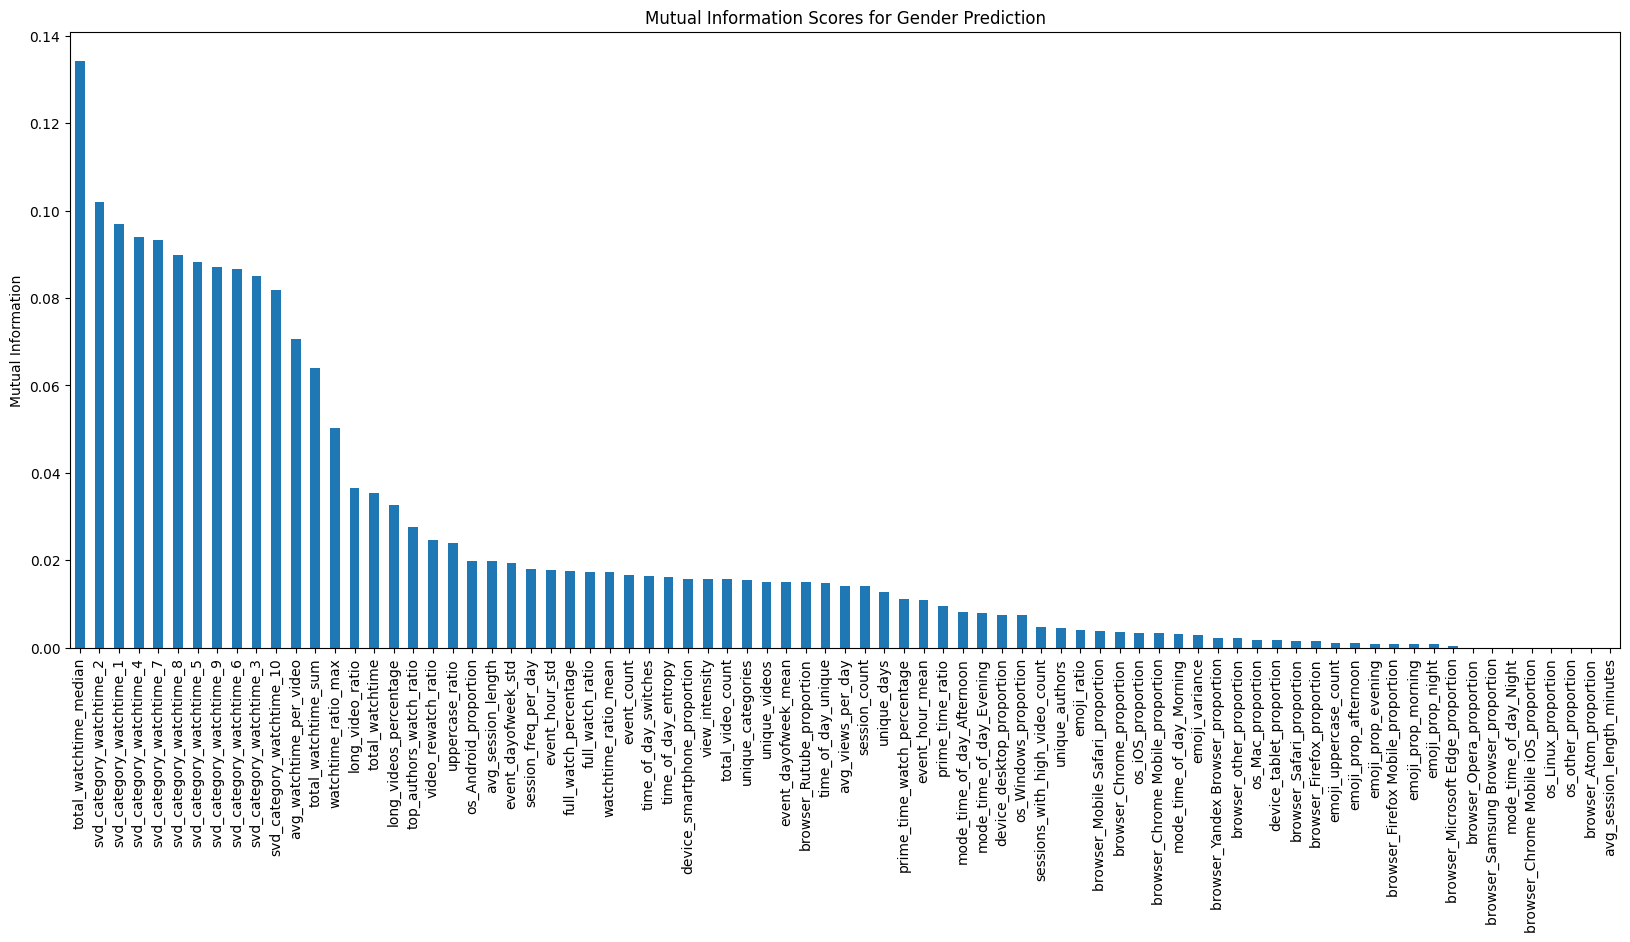

In [66]:
from sklearn.feature_selection import mutual_info_classif

# Вычисление взаимной информации для gender
mi_gender = mutual_info_classif(X, y_gender_encoded, discrete_features='auto', random_state=42)
mi_gender_series = pd.Series(mi_gender, index=feature_cols).sort_values(ascending=False)

print("Взаимная информация по признакам для предсказания пола:")
print(mi_gender_series)

# Визуализация
plt.figure(figsize=(20, 8))
mi_gender_series.plot(kind='bar')
plt.title('Mutual Information Scores for Gender Prediction')
plt.ylabel('Mutual Information')
plt.show()

Взаимная информация по признакам для предсказания возрастной группы:
total_watchtime_median            0.073611
svd_category_watchtime_8          0.033790
svd_category_watchtime_5          0.033230
svd_category_watchtime_7          0.032925
svd_category_watchtime_9          0.032565
                                    ...   
browser_Opera_proportion          0.000000
emoji_prop_night                  0.000000
emoji_prop_evening                0.000000
emoji_prop_afternoon              0.000000
sessions_with_high_video_count    0.000000
Length: 79, dtype: float64


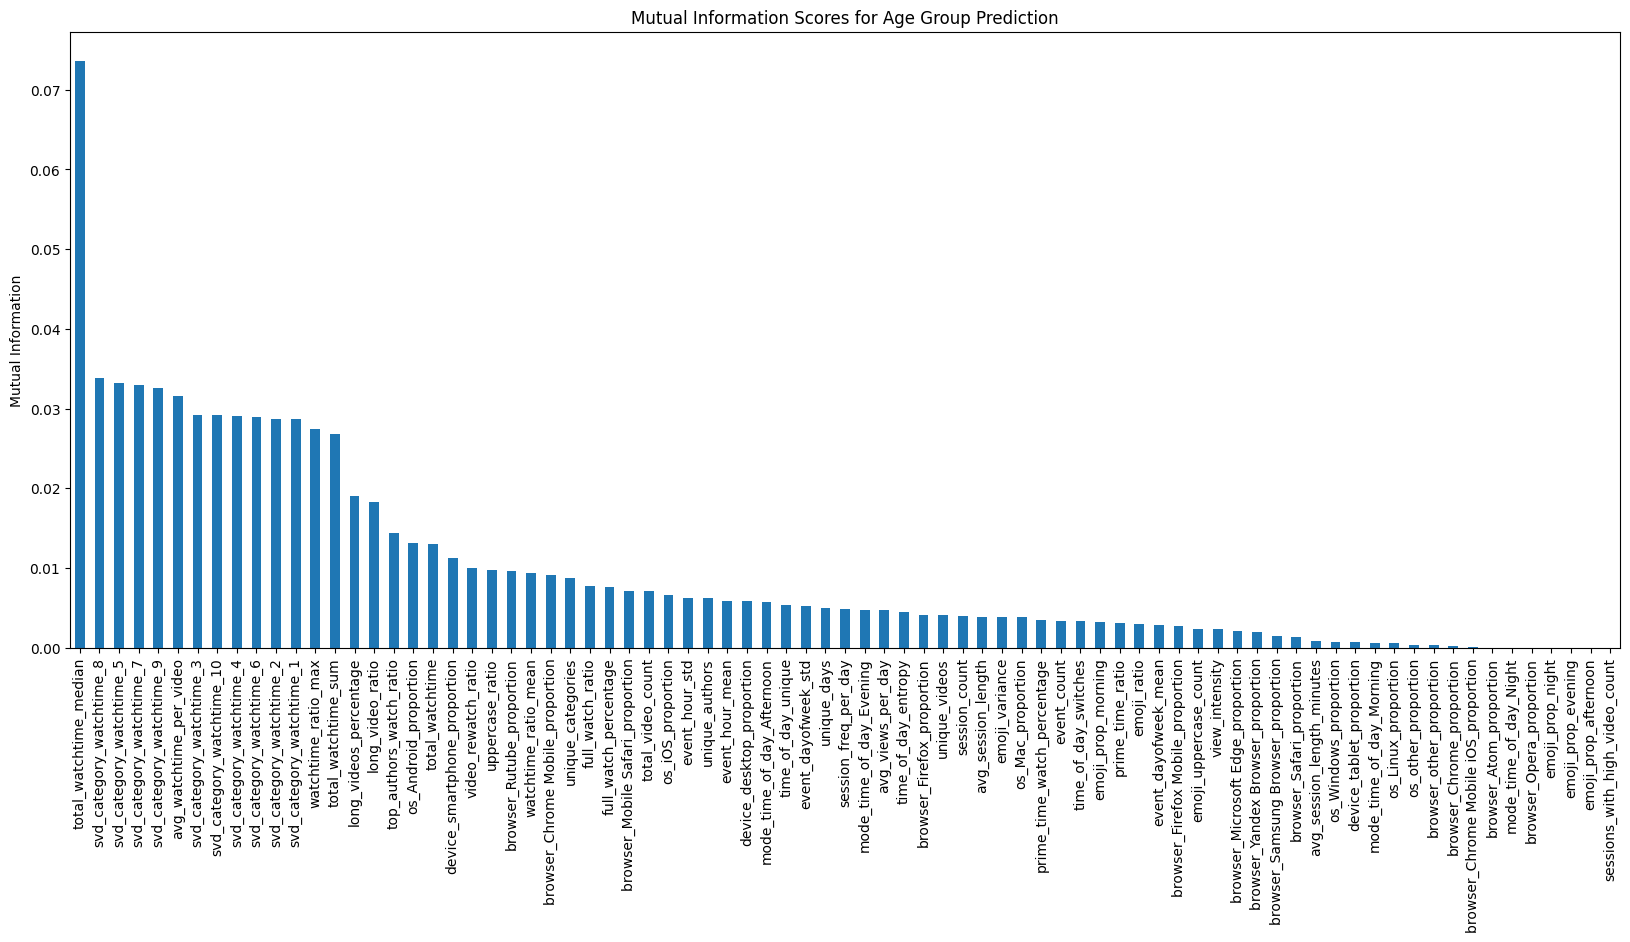

In [67]:
# Вычисление взаимной информации для age
mi_age = mutual_info_classif(X, y_age_encoded, discrete_features='auto', random_state=42)
mi_age_series = pd.Series(mi_age, index=feature_cols).sort_values(ascending=False)

print("Взаимная информация по признакам для предсказания возрастной группы:")
print(mi_age_series)

# Визуализация
plt.figure(figsize=(20, 8))
mi_age_series.plot(kind='bar')
plt.title('Mutual Information Scores for Age Group Prediction')
plt.ylabel('Mutual Information')
plt.show()

# Model Training and Evaluation

## Defining a Function to Train and Evaluate Models

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

def train_and_evaluate(model, X_train, y_train, X_test, y_test, target_name, target_names):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    f1_weighted = f1_score(y_test, predictions, average='weighted')
    print(f"Accuracy for {target_name}: {acc:.4f}")
    print(f"Classification Report for {target_name}:\n{classification_report(y_test, predictions, target_names=target_names)}")
    # Optionally, display confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {target_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return acc, f1_weighted


## Logistic Regression

In [42]:
X_train_age.head()

,total_watchtime_median,event_count,browser_Atom_proportion,browser_Chrome_proportion,browser_Chrome Mobile_proportion,browser_Chrome Mobile iOS_proportion,browser_Firefox_proportion,browser_Firefox Mobile_proportion,browser_Microsoft Edge_proportion,browser_Mobile Safari_proportion,...,mode_time_of_day_Afternoon,mode_time_of_day_Evening,mode_time_of_day_Morning,mode_time_of_day_Night,emoji_prop_morning,emoji_prop_afternoon,emoji_prop_evening,emoji_prop_night,emoji_variance,time_of_day_switches
11347,60.663070,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,False,False,False,0.0,0.0,0.0,0.0,0.0,13
164006,2.522936,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,True,False,False,False,0.0,0.0,0.0,0.0,0.0,3
82168,52.707257,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,False,True,False,0.0,0.0,0.0,0.0,0.0,4
2547,5.582304,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,0.0,0.0,0.0,0.0,0.0,2
142880,59.964742,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,True,False,False,0.0,0.0,0.0,0.0,0.0,1


In [65]:
X_train_age.columns.values

array(['total_watchtime_median', 'event_count', 'browser_Atom_proportion',
       'browser_Chrome_proportion', 'browser_Chrome Mobile_proportion',
       'browser_Chrome Mobile iOS_proportion',
       'browser_Firefox_proportion', 'browser_Firefox Mobile_proportion',
       'browser_Microsoft Edge_proportion',
       'browser_Mobile Safari_proportion', 'browser_Opera_proportion',
       'browser_Rutube_proportion', 'browser_Safari_proportion',
       'browser_Samsung Browser_proportion',
       'browser_Yandex Browser_proportion', 'browser_other_proportion',
       'os_Android_proportion', 'os_Linux_proportion',
       'os_Mac_proportion', 'os_Windows_proportion', 'os_iOS_proportion',
       'os_other_proportion', 'device_desktop_proportion',
       'device_smartphone_proportion', 'device_tablet_proportion',
       'event_hour_mean', 'event_hour_std', 'event_dayofweek_mean',
       'event_dayofweek_std', 'unique_videos', 'unique_categories',
       'unique_authors', 'watchtime_ratio_me

Logistic Regression for Gender Prediction
Accuracy for Gender: 0.6977
Classification Report for Gender:
              precision    recall  f1-score   support

        male       0.72      0.64      0.68     18020
      female       0.68      0.75      0.71     17983

    accuracy                           0.70     36003
   macro avg       0.70      0.70      0.70     36003
weighted avg       0.70      0.70      0.70     36003



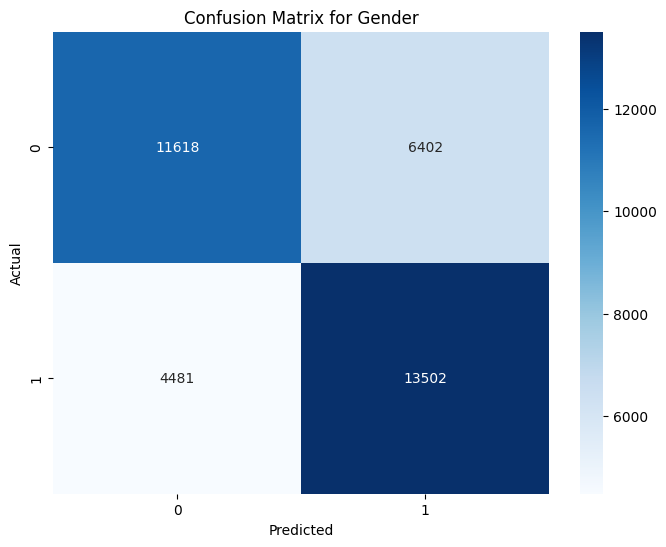

Logistic Regression for Age Prediction
Accuracy for Age Group: 0.3774
Classification Report for Age Group:
              precision    recall  f1-score   support

        9-20       0.00      0.00      0.00      1518
       20-30       0.41      0.24      0.31     12627
       30-40       0.37      0.80      0.50     13120
       40-60       0.36      0.00      0.01      8738

    accuracy                           0.38     36003
   macro avg       0.29      0.26      0.20     36003
weighted avg       0.37      0.38      0.29     36003



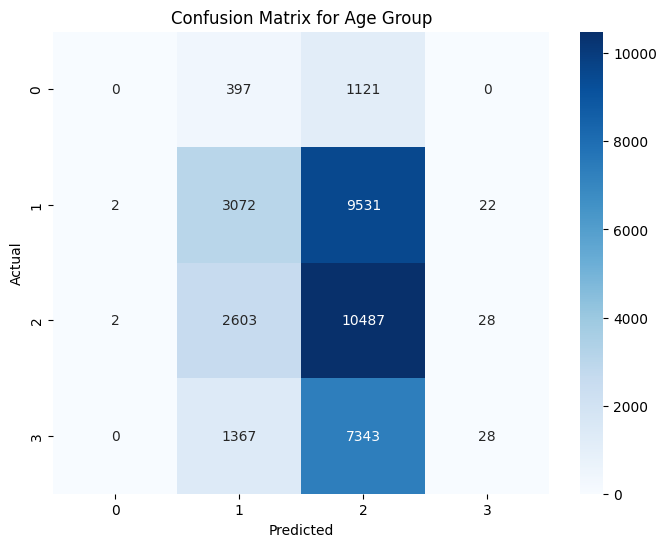

TOTAL_METRIC:  0.41417169252709257


In [63]:
# Logistic Regression for Gender
print("Logistic Regression for Gender Prediction")
lr_gender = LogisticRegression(max_iter=1000)
acc, _ = train_and_evaluate(lr_gender, X_train_gender, y_train_gender, X_test_gender, y_test_gender, 'Gender', target_names=['male', 'female'])

# Logistic Regression for Age
print("Logistic Regression for Age Prediction")
lr_age = LogisticRegression(max_iter=1000, multi_class='multinomial')
_, f1_weighted = train_and_evaluate(lr_age, X_train_age, y_train_age, X_test_age, y_test_age, 'Age Group', target_names=['9-20', '20-30', '30-40', '40-60'])


print('TOTAL_METRIC: ', (acc*0.3+f1_weighted*0.7))

## Random Forest

Random Forest for Gender Prediction
Accuracy for Gender: 0.7210
Classification Report for Gender:
              precision    recall  f1-score   support

        male       0.75      0.67      0.71     18020
      female       0.70      0.77      0.73     17983

    accuracy                           0.72     36003
   macro avg       0.72      0.72      0.72     36003
weighted avg       0.72      0.72      0.72     36003



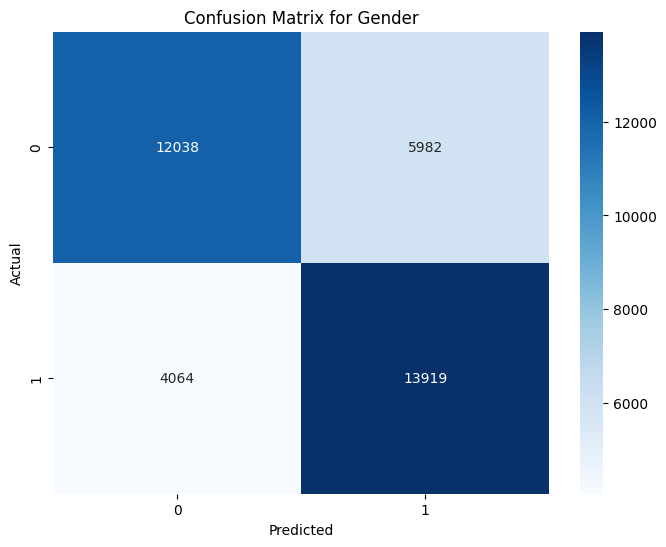

Random Forest for Age Prediction
Accuracy for Age Group: 0.4549
Classification Report for Age Group:
              precision    recall  f1-score   support

        9-20       0.00      0.00      0.00      1518
       20-30       0.49      0.56      0.52     12627
       30-40       0.41      0.42      0.42     13120
       40-60       0.47      0.43      0.45      8738

    accuracy                           0.45     36003
   macro avg       0.34      0.35      0.35     36003
weighted avg       0.43      0.45      0.44     36003



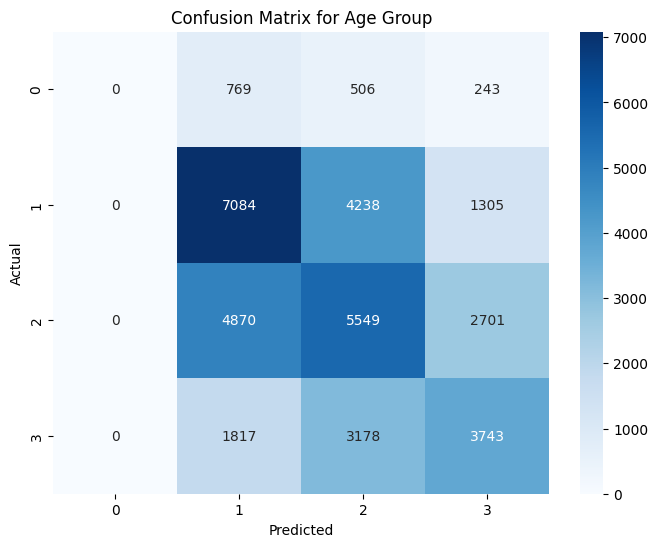

TOTAL_METRIC:  0.5268082857915692


In [64]:
# Random Forest for Gender
print("Random Forest for Gender Prediction")
rf_gender = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, criterion='gini')
acc, _ = train_and_evaluate(rf_gender, X_train_gender, y_train_gender, X_test_gender, y_test_gender, 'Gender', target_names=['male', 'female'])

# Random Forest for Age
print("Random Forest for Age Prediction")
rf_age = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=5, max_depth=10, criterion='gini')
_, f1_weighted = train_and_evaluate(rf_age, X_train_age, y_train_age, X_test_age, y_test_age, 'Age Group', target_names=['9-20', '20-30', '30-40', '40-60'])

print('TOTAL_METRIC: ', (acc*0.3+f1_weighted*0.7))

In [48]:
print(X_train_gender.isnull().sum())


total_watchtime_median              0
event_count                         0
browser_Atom_proportion             0
browser_Chrome_proportion           0
browser_Chrome Mobile_proportion    0
                                   ..
emoji_prop_afternoon                0
emoji_prop_evening                  0
emoji_prop_night                    0
emoji_variance                      0
time_of_day_switches                0
Length: 148, dtype: int64


## CatBoost

CatBoost for Gender Prediction
Learning rate set to 0.086013
0:	learn: 0.6742328	total: 28.5ms	remaining: 28.5s
50:	learn: 0.5440569	total: 1.49s	remaining: 27.7s
100:	learn: 0.5326139	total: 4.22s	remaining: 37.6s
150:	learn: 0.5258825	total: 6.51s	remaining: 36.6s
200:	learn: 0.5203308	total: 8.63s	remaining: 34.3s
250:	learn: 0.5159861	total: 10.4s	remaining: 30.9s
300:	learn: 0.5121373	total: 11.6s	remaining: 27s
350:	learn: 0.5088540	total: 12.9s	remaining: 23.8s
400:	learn: 0.5059278	total: 14.1s	remaining: 21.1s
450:	learn: 0.5031351	total: 15.4s	remaining: 18.7s
500:	learn: 0.5004959	total: 16.6s	remaining: 16.5s
550:	learn: 0.4980038	total: 19s	remaining: 15.5s
600:	learn: 0.4956937	total: 21s	remaining: 13.9s
650:	learn: 0.4933341	total: 23.2s	remaining: 12.4s
700:	learn: 0.4908629	total: 24.7s	remaining: 10.5s
750:	learn: 0.4884735	total: 25.9s	remaining: 8.6s
800:	learn: 0.4864401	total: 27.2s	remaining: 6.75s
850:	learn: 0.4842692	total: 28.4s	remaining: 4.97s
900:	learn: 

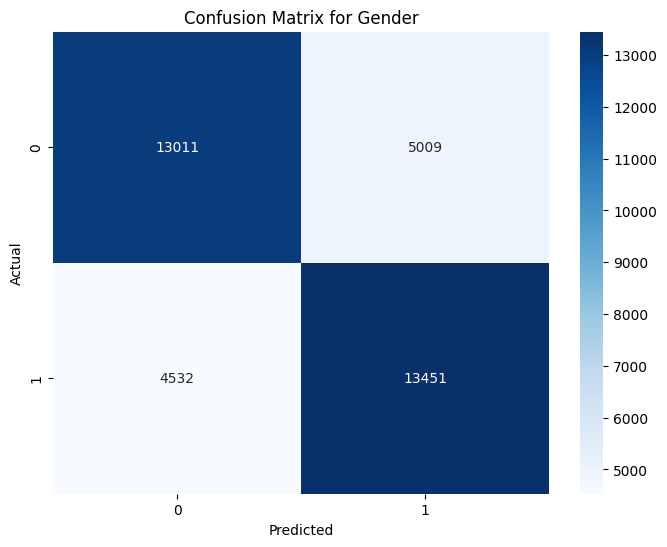

CatBoost for Age Prediction
0:	learn: 1.3828496	total: 56.4ms	remaining: 56.4s
50:	learn: 1.2651673	total: 3.75s	remaining: 1m 9s
100:	learn: 1.2073966	total: 7.06s	remaining: 1m 2s
150:	learn: 1.1776564	total: 10.2s	remaining: 57.5s
200:	learn: 1.1615692	total: 13.3s	remaining: 53s
250:	learn: 1.1523193	total: 18.7s	remaining: 55.9s
300:	learn: 1.1466243	total: 23.8s	remaining: 55.3s
350:	learn: 1.1427321	total: 26.7s	remaining: 49.4s
400:	learn: 1.1395315	total: 30.9s	remaining: 46.2s
450:	learn: 1.1369655	total: 36.1s	remaining: 43.9s
500:	learn: 1.1347980	total: 39.7s	remaining: 39.5s
550:	learn: 1.1329909	total: 42.5s	remaining: 34.7s
600:	learn: 1.1312106	total: 46.9s	remaining: 31.1s
650:	learn: 1.1297272	total: 51.8s	remaining: 27.8s
700:	learn: 1.1282933	total: 55.3s	remaining: 23.6s
750:	learn: 1.1270671	total: 58.2s	remaining: 19.3s
800:	learn: 1.1259454	total: 1m	remaining: 15.2s
850:	learn: 1.1248974	total: 1m 3s	remaining: 11.2s
900:	learn: 1.1238100	total: 1m 6s	remainin

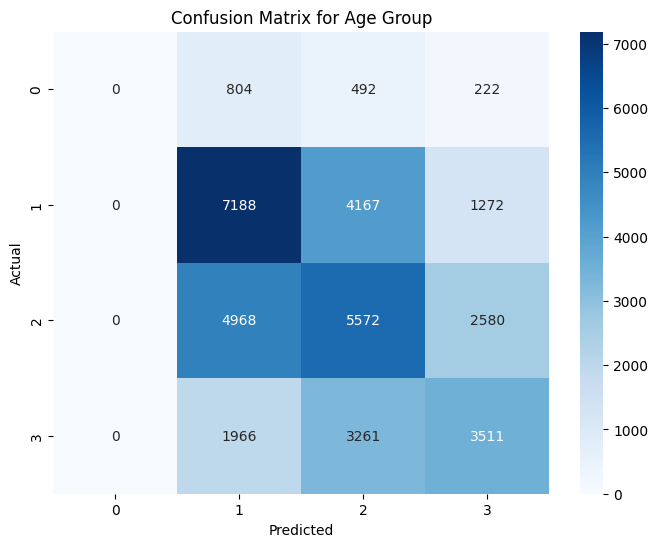

TOTAL_METRIC:  0.5284989697806421


In [51]:
# CatBoost for Gender
print("CatBoost for Gender Prediction")
cb_gender = CatBoostClassifier(iterations=1000, verbose=50, random_state=42)
acc, _ = train_and_evaluate(cb_gender, X_train_gender, y_train_gender, X_test_gender, y_test_gender, 'Gender', target_names=['male', 'female'])

# CatBoost for Age
print("CatBoost for Age Prediction")
cb_age = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=5, loss_function='MultiClass', random_seed=42, verbose=50)
_, f1_weighted = train_and_evaluate(cb_age, X_train_age, y_train_age, X_test_age, y_test_age, 'Age Group', target_names=['9-20', '20-30', '30-40', '40-60'])

print('TOTAL_METRIC: ', (acc*0.3+f1_weighted*0.7))

In [50]:
user_video_counts = train_events.groupby('viewer_uid').size().reset_index(name='video_count')
bins = [1, 5, 10, 20, 50, 100, float('inf')]
user_video_counts['video_count_group'] = pd.cut(user_video_counts['video_count'], bins=bins, labels=False)


In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Пример использования learning_curve для вашей модели
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10), 
                                                            scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label="Training accuracy")
    plt.plot(train_sizes, test_scores_mean, label="Validation accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Training set size')
    plt.legend()
    plt.show()

# Пример вызова функции
plot_learning_curve(cb_gender, X, y_gender)


In [85]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/e2/7b/8c1b410cd0604cee9a167a19f7e1746f5b92ae7d02ad574ab560b73c5a48/xgboost-2.1.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 825.8 kB/s eta 0:02:32
   ---------------------------------------- 0.1/124.9 MB 660.6 kB/s eta 0:03:09
   ---------------------------------------- 0.2/124.9 MB 919.0 kB/s eta 0:02:16
   ---------------------------------------- 0.3/124.9 MB 1.1 MB/s eta 0:01:51
   ---------------------------------------- 0.3/124.9 MB 1.1 MB/s eta 0:01:51
   ---------------------------------------- 0.3/124.9 MB 1.2 MB/s eta 0:01:47
   --------------------------------


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [89]:
# Определение классификаторов и их гиперпараметров
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, solver='liblinear'),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.7, 1.0]
        }
    }
}

# Определение метрик для каждой задачи
# Для 'sex' используем accuracy
accuracy_scorer = make_scorer(accuracy_score)

# Для 'age_class' используем f1_weighted
f1_scorer = make_scorer(f1_score, average='weighted')

# Функция для выполнения Grid Search и обучения модели
def train_model(X_train, y_train, model_info, scoring, cv=5):
    grid = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    return grid

# Хранение лучших моделей и их метрик
best_models = {}
metrics = {}

# Обучение моделей для задачи 'sex'
print("Обучение моделей для классификации 'sex'...")
for model_name, model_info in models.items():
    print(f'Обучение модели: {model_name}')
    grid = train_model(X_train_gender, y_train_gender, model_info, scoring=accuracy_scorer)
    best_models[f'sex_{model_name}'] = grid.best_estimator_
    
    # Предсказания на тестовой выборке
    y_pred = grid.predict(X_test_gender)
    
    # Вычисление метрикgender, y_pred)
    f1 = f1_score(y_test_gender, y_pred, average='weighted')  # Не используется для 'sex', но можно сохранить
    metrics[f'sex_{model_name}'] = {
        'accuracy': acc,
        'f1_weighted': f1
    }
    print(f'Модель: {model_name}, Accuracy: {acc:.4f}')

# Обучение моделей для задачи 'age_class'
print("\nОбучение моделей для классификации 'age_class'...")
for model_name, model_info in models.items():
    print(f'Обучение модели: {model_name}')
    grid = train_model(X_train_age, y_train_age, model_info, scoring=f1_scorer)
    best_models[f'age_{model_name}'] = grid.best_estimator_
    
    # Предсказания на тестовой выборке
    y_pred = grid.predict(X_test_age)
    
    # Вычисление метрик
    acc = accuracy_score(y_test_age, y_pred)  # Не используется для 'age_class', но можно сохранить
    f1 = f1_score(y_test_age, y_pred, average='weighted')
    metrics[f'age_{model_name}'] = {
        'accuracy': acc,
        'f1_weighted': f1
    }
    print(f'Модель: {model_name}, F1_weighted: {f1:.4f}')

# Определение лучших моделей для каждой задачи
# Для 'sex' на основе Accuracy
best_sex_model_name = max(
    [k for k in metrics.keys() if k.startswith('sex_')],
    key=lambda x: metrics[x]['accuracy']
)
best_sex_model = best_models[best_sex_model_name]
best_sex_accuracy = metrics[best_sex_model_name]['accuracy']

# Для 'age_class' на основе F1_weighted
best_age_model_name = max(
    [k for k in metrics.keys() if k.startswith('age_')],
    key=lambda x: metrics[x]['f1_weighted']
)
best_age_model = best_models[best_age_model_name]
best_age_f1 = metrics[best_age_model_name]['f1_weighted']

print("\nЛучшие модели:")
print(f"Для 'sex': {best_sex_model_name} с Accuracy = {best_sex_accuracy:.4f}")
print(f"Для 'age_class': {best_age_model_name} с F1_weighted = {best_age_f1:.4f}")

# Вычисление итоговой метрики
final_metric = 0.3 * best_sex_accuracy + 0.7 * best_age_f1
print(f"\nИтоговая метрика (0.3 * Accuracy_sex + 0.7 * F1_weighted_age_class): {final_metric:.4f}")

# Сохранение лучших моделей
joblib.dump(best_sex_model, 'best_sex_model.joblib')
joblib.dump(best_age_model, 'best_age_model.joblib')

# Опционально: сохранение метрик
metrics_df = pd.DataFrame(metrics).T
metrics_df.to_csv('model_metrics.csv')

Обучение моделей для классификации 'sex'...
Обучение модели: LogisticRegression
Модель: LogisticRegression, Accuracy: 0.7210
Обучение модели: RandomForest
Модель: RandomForest, Accuracy: 0.7210
Обучение модели: XGBoost
Модель: XGBoost, Accuracy: 0.7210

Обучение моделей для классификации 'age_class'...
Обучение модели: LogisticRegression
Модель: LogisticRegression, F1_weighted: 0.4317
Обучение модели: RandomForest
Модель: RandomForest, F1_weighted: 0.4533
Обучение модели: XGBoost
Модель: XGBoost, F1_weighted: 0.4576

Лучшие модели:
Для 'sex': sex_LogisticRegression с Accuracy = 0.7210
Для 'age_class': age_XGBoost с F1_weighted = 0.4576

Итоговая метрика (0.3 * Accuracy_sex + 0.7 * F1_weighted_age_class): 0.5366


CatBoost for Age Prediction
0:	learn: 1.3828496	total: 73ms	remaining: 1m 12s
50:	learn: 1.2651673	total: 4.6s	remaining: 1m 25s
100:	learn: 1.2073966	total: 9.59s	remaining: 1m 25s
150:	learn: 1.1776564	total: 12.9s	remaining: 1m 12s
200:	learn: 1.1615692	total: 17.1s	remaining: 1m 7s
250:	learn: 1.1523193	total: 26.8s	remaining: 1m 20s
300:	learn: 1.1466243	total: 30.1s	remaining: 1m 9s
350:	learn: 1.1427321	total: 34.5s	remaining: 1m 3s
400:	learn: 1.1395315	total: 39.5s	remaining: 59s
450:	learn: 1.1369655	total: 42.5s	remaining: 51.7s
500:	learn: 1.1347980	total: 45.4s	remaining: 45.3s
550:	learn: 1.1329909	total: 50s	remaining: 40.8s
600:	learn: 1.1312106	total: 55.2s	remaining: 36.6s
650:	learn: 1.1297272	total: 58.1s	remaining: 31.1s
700:	learn: 1.1282933	total: 1m	remaining: 26s
750:	learn: 1.1270671	total: 1m 5s	remaining: 21.8s
800:	learn: 1.1259454	total: 1m 10s	remaining: 17.5s
850:	learn: 1.1248974	total: 1m 13s	remaining: 12.8s
900:	learn: 1.1238100	total: 1m 16s	remaini

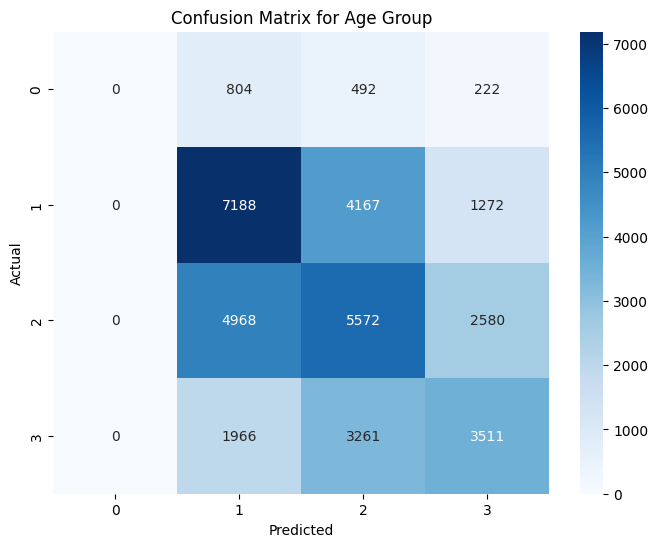

In [92]:
# CatBoost for Age
print("CatBoost for Age Prediction")
cb_age = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=5, loss_function='MultiClass', random_seed=42, verbose=50)
_, f1_weighted = train_and_evaluate(cb_age, X_train_age, y_train_age, X_test_age, y_test_age, 'Age Group', target_names=['9-20', '20-30', '30-40', '40-60'])

In [ ]:
required_columns = ['sex', 'age_class']
for col in required_columns:
    if col not in user_features.columns:
        raise ValueError(f"Целевая переменная '{col}' отсутствует в DataFrame.")

# Разделение данных на признаки и целевые переменные
feature_cols = [col for col in user_features.columns if col not in ['viewer_uid', 'sex', 'age_class', 'age']]
X = user_features[feature_cols]
y_gender = user_features['sex']
y_age = user_features['age_class']

# Кодирование целевых переменных
le_gender = LabelEncoder()
y_gender_encoded = le_gender.fit_transform(y_gender)

le_age = LabelEncoder()
y_age_encoded = le_age.fit_transform(y_age)

# Определение пороговых значений
filter_features = {
    'event_count': [1, 3, 5, 7, 10, 15],
    'unique_videos': [1, 3, 5, 7, 10, 15],
    'unique_days': [1, 3, 5, 7, 10, 15],
    'total_watchtime': [100, 1000, 3000, 5000, 7000, 10000]  # Пороговые значения для total_watchtime
}

# Функция для фильтрации данных
def filter_data(df, feature, threshold):
    """
    Фильтрует DataFrame, оставляя только пользователей, у которых значение в feature >= threshold.
    """
    return df[df[feature] >= threshold]

# Определение классификаторов и их гиперпараметров
classifiers = {
    'CatBoost': {
        'model': CatBoostClassifier(verbose=0, random_state=42),
        'params': {
            'depth': [6],
            'learning_rate': [0.01],
            'iterations': [700]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'max_depth': [6],
            'learning_rate': [0.01],
            'n_estimators': [700],
        }
    }
}

# Определение метрик для Grid Search
accuracy_scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')

# Функция для обучения и оценки модели
def train_and_evaluate(X, y, classifier_name, classifier_info, scoring):
    """
    Обучает модель с использованием GridSearchCV и возвращает лучшую модель и её гиперпараметры.
    """
    grid = GridSearchCV(
        estimator=classifier_info['model'],
        param_grid=classifier_info['params'],
        scoring=scoring,
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X, y)
    best_model = grid.best_estimator_
    return best_model, grid.best_params_

# Хранение результатов
results = []

# Перебор всех признаков и пороговых значений
for feature, thresholds in filter_features.items():
    for threshold in thresholds:
        print(f"\nФильтрация по {feature} >= {threshold}")
        
        # Фильтрация данных
        filtered_X = filter_data(X, feature, threshold)
        filtered_y_gender = y_gender_encoded[filtered_X.index]
        filtered_y_age = y_age_encoded[filtered_X.index]
        
        # Проверка достаточности данных
        if len(filtered_X) < 100:
            print(f"Недостаточно данных после фильтрации: {len(filtered_X)} примеров. Пропуск.")
            continue
        
        # Разделение на обучающую и тестовую выборки
        X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(
            filtered_X, filtered_y_gender, test_size=0.2, random_state=42, stratify=filtered_y_gender
        )
        
        X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
            filtered_X, filtered_y_age, test_size=0.2, random_state=42, stratify=filtered_y_age
        )
        
        # Обучение и оценка моделей для задачи 'sex'
        for clf_name, clf_info in classifiers.items():
            print(f"Обучение модели {clf_name} для 'sex'")
            best_model_gender, best_params_gender = train_and_evaluate(
                X_train_gender, y_train_gender, clf_name, clf_info, accuracy_scorer
            )
            y_pred_gender = best_model_gender.predict(X_test_gender)
            acc_gender = accuracy_score(y_test_gender, y_pred_gender)
            print(f"{clf_name} для 'sex' - Accuracy: {acc_gender:.4f}")
            
            # Обучение и оценка моделей для задачи 'age_class'
            print(f"Обучение модели {clf_name} для 'age_class'")
            best_model_age, best_params_age = train_and_evaluate(
                X_train_age, y_train_age, clf_name, clf_info, f1_scorer
            )
            y_pred_age = best_model_age.predict(X_test_age)
            f1_age = f1_score(y_test_age, y_pred_age, average='weighted')
            print(f"{clf_name} для 'age_class' - F1_weighted: {f1_age:.4f}")
            
            # Вычисление итоговой метрики
            final_metric = 0.3 * acc_gender + 0.7 * f1_age
            print(f"Итоговая метрика: {final_metric:.4f}")
            
            # Сохранение результатов
            results.append({
                'feature': feature,
                'threshold': threshold,
                'classifier': clf_name,
                'best_params_sex': best_params_gender,
                'accuracy_sex': acc_gender,
                'best_params_age': best_params_age,
                'f1_weighted_age': f1_age,
                'final_metric': final_metric
            })


Фильтрация по event_count >= 1
Обучение модели CatBoost для 'sex'
CatBoost для 'sex' - Accuracy: 0.7269
Обучение модели CatBoost для 'age_class'
CatBoost для 'age_class' - F1_weighted: 0.4396
Итоговая метрика: 0.5258
Обучение модели XGBoost для 'sex'
XGBoost для 'sex' - Accuracy: 0.7325
Обучение модели XGBoost для 'age_class'
XGBoost для 'age_class' - F1_weighted: 0.4475
Итоговая метрика: 0.5330

Фильтрация по event_count >= 3
Обучение модели CatBoost для 'sex'
CatBoost для 'sex' - Accuracy: 0.7463
Обучение модели CatBoost для 'age_class'
CatBoost для 'age_class' - F1_weighted: 0.4455
Итоговая метрика: 0.5357
Обучение модели XGBoost для 'sex'
XGBoost для 'sex' - Accuracy: 0.7487
Обучение модели XGBoost для 'age_class'
XGBoost для 'age_class' - F1_weighted: 0.4594
Итоговая метрика: 0.5462

Фильтрация по event_count >= 5
Обучение модели CatBoost для 'sex'
CatBoost для 'sex' - Accuracy: 0.7682
Обучение модели CatBoost для 'age_class'
CatBoost для 'age_class' - F1_weighted: 0.4581
Итогова